# VQA model accuracy

In [148]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import seaborn as sns
import torchvision
import pprint
import pandas as pd
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import json
import matplotlib.pyplot as plt
from PIL import Image
import time
import re, sys
import os
import copy
import shutil
import io
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

%matplotlib inline

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

PyTorch Version:  1.13.1+cu117
Torchvision Version:  0.14.1+cu117
cuda:0


**Load VizWiz test set data** (with PromptCap model output)

In [149]:
with open('/media/arnau/SSD/VizWiz/models/hf_model_test_res.json', encoding='UTF-8') as jf:
    model_output_data = json.load(jf)

**Load VizWiz test set data** (with extra models output)

In [150]:
with open('/media/arnau/SSD/VizWiz/models/hf_extra_models_test_res.json', encoding='UTF-8') as jf:
    other_models_output_data = json.load(jf)

# Add GT answers
for img_name, data in other_models_output_data.items():
    other_models_output_data[img_name]["gt_answers"] = model_output_data[img_name]["gt_answers"]

In [151]:
val_imgs = os.listdir('/media/arnau/SSD/VizWiz/data/captioning/val/')
test_imgs = list(model_output_data.keys())
test_fin_imgs = [img for img in test_imgs if img in val_imgs]

if os.path.exists("/media/arnau/SSD/VizWiz/data/test_imgs/") == False:
    os.mkdir("/media/arnau/SSD/VizWiz/data/test_imgs/")
    
    # Copy test images to separate folder
    for img in test_fin_imgs:
        original = f'/media/arnau/SSD/VizWiz/data/captioning/val/{img}'
        target = f"/media/arnau/SSD/VizWiz/data/test_imgs/{img}"
        shutil.copyfile(original, target)

In [152]:
get_model_types = lambda d : [el 
                               for el in list(d[next(iter(d))].keys()) 
                               if el not in ['question', 'gt_answers']]

Merge both dictionaries into a single one

In [153]:
merged = model_output_data.copy()

for typ in get_model_types(other_models_output_data):
    for img_name, data in merged.items():
        try:
            other_model_result = other_models_output_data[img_name][typ]
            merged[img_name][typ] = other_model_result
        except:
            pass
        
model_output_data = merged

Show all models 

In [154]:
get_model_types(model_output_data)

['HF_OCR_google_answer',
 'HF_OCR_answer',
 'HF_NON_OCR_answer',
 'ViLT',
 'SF_LAVIS',
 'BLIP2-VQA',
 'BLIP2-CTX-VQA']

## Models accuracy
Various VQA models evaluated on VizWiz test set

### Helper functions

In [155]:
def remove_periods(q):
    
    outText = q
    puncts = [';', r"/", '[', ']', '"', '{', '}',
                                 '(', ')', '=', '+', '\\', '_', '-',
                                 '>', '<', '@', '`', ',', '?', '!']
    comma_strip = re.compile("(\d)(\,)(\d)")
    periodStrip  = re.compile("(?!<=\d)(\.)(?!\d)")
    for p in puncts:
        if (p + ' ' in q or ' ' + p in q) or (re.search(comma_strip, q) != None):
            outText = outText.replace(p, '')
        else:
            outText = outText.replace(p, ' ')
            outText = periodStrip.sub("",
                                           outText,
                                           re.UNICODE)
    return outText

In [156]:


def num_words_to_digit(q):
    
    outText = []
    tempText = q.lower().split()
    manualMap  = { 'none': '0',
                    'zero': '0',
                    'one': '1',
                     'two': '2',
                     'three': '3',
                     'four': '4',
                     'five': '5',
                     'six': '6',
                     'seven': '7',
                     'eight': '8',
                     'nine': '9',
                     'ten': '10'}
    articles     = ['a',
                             'an',
                             'the'
                    ]
    contractions = {"aint": "ain't", "arent": "aren't", "cant": "can't", "couldve": "could've", "couldnt": "couldn't", \
                            "couldn'tve": "couldn't've", "couldnt've": "couldn't've", "didnt": "didn't", "doesnt": "doesn't", "dont": "don't", "hadnt": "hadn't", \
                            "hadnt've": "hadn't've", "hadn'tve": "hadn't've", "hasnt": "hasn't", "havent": "haven't", "hed": "he'd", "hed've": "he'd've", \
                            "he'dve": "he'd've", "hes": "he's", "howd": "how'd", "howll": "how'll", "hows": "how's", "Id've": "I'd've", "I'dve": "I'd've", \
                            "Im": "I'm", "Ive": "I've", "isnt": "isn't", "itd": "it'd", "itd've": "it'd've", "it'dve": "it'd've", "itll": "it'll", "let's": "let's", \
                            "maam": "ma'am", "mightnt": "mightn't", "mightnt've": "mightn't've", "mightn'tve": "mightn't've", "mightve": "might've", \
                            "mustnt": "mustn't", "mustve": "must've", "neednt": "needn't", "notve": "not've", "oclock": "o'clock", "oughtnt": "oughtn't", \
                            "ow's'at": "'ow's'at", "'ows'at": "'ow's'at", "'ow'sat": "'ow's'at", "shant": "shan't", "shed've": "she'd've", "she'dve": "she'd've", \
                            "she's": "she's", "shouldve": "should've", "shouldnt": "shouldn't", "shouldnt've": "shouldn't've", "shouldn'tve": "shouldn't've", \
                            "somebody'd": "somebodyd", "somebodyd've": "somebody'd've", "somebody'dve": "somebody'd've", "somebodyll": "somebody'll", \
                            "somebodys": "somebody's", "someoned": "someone'd", "someoned've": "someone'd've", "someone'dve": "someone'd've", \
                            "someonell": "someone'll", "someones": "someone's", "somethingd": "something'd", "somethingd've": "something'd've", \
                            "something'dve": "something'd've", "somethingll": "something'll", "thats": "that's", "thered": "there'd", "thered've": "there'd've", \
                            "there'dve": "there'd've", "therere": "there're", "theres": "there's", "theyd": "they'd", "theyd've": "they'd've", \
                            "they'dve": "they'd've", "theyll": "they'll", "theyre": "they're", "theyve": "they've", "twas": "'twas", "wasnt": "wasn't", \
                            "wed've": "we'd've", "we'dve": "we'd've", "weve": "we've", "werent": "weren't", "whatll": "what'll", "whatre": "what're", \
                            "whats": "what's", "whatve": "what've", "whens": "when's", "whered": "where'd", "wheres": "where's", "whereve": "where've", \
                            "whod": "who'd", "whod've": "who'd've", "who'dve": "who'd've", "wholl": "who'll", "whos": "who's", "whove": "who've", "whyll": "why'll", \
                            "whyre": "why're", "whys": "why's", "wont": "won't", "wouldve": "would've", "wouldnt": "wouldn't", "wouldnt've": "wouldn't've", \
                            "wouldn'tve": "wouldn't've", "yall": "y'all", "yall'll": "y'all'll", "y'allll": "y'all'll", "yall'd've": "y'all'd've", \
                            "y'alld've": "y'all'd've", "y'all'dve": "y'all'd've", "youd": "you'd", "youd've": "you'd've", "you'dve": "you'd've", \
                            "youll": "you'll", "youre": "you're", "youve": "you've"
                            }
    for word in tempText:
        word = manualMap.setdefault(word, word)
        if word not in articles:
            outText.append(word)
        else:
            pass

    for wordId, word in enumerate(outText):
        if word in contractions:
            outText[wordId] = contractions[word]
    outText = ' '.join(outText)
    return outText

In [157]:
def updateProgress(progress):
    
    barLength = 20
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rFinshed Percent: [{0}] {1}% {2}".format( "#"*block + "-"*(barLength-block), int(progress*100), status)
    sys.stdout.write(text)
    sys.stdout.flush()

### Evaluation

In [158]:
def evaluate_acc_promptcap(model_output_data, model_type):
    """ 
    Calculates accuracy metric for VQA model
    """
    
    accQA       = []
    step = 0
    
    data = model_output_data.copy()
    
    for img, img_info in data.items():
        question = img_info["question"]
        gtanswers = img_info["gt_answers"]
        for ans in gtanswers:
            if type(ans['answer']) == str:
                ans['answer'] = ans['answer'].replace('\n', ' ').replace('\t', ' ').strip().lower()
            else:
                ans['answer'] = ' '.join(ans['answer'])
        try:
            resAns = img_info[model_type]
            resAns = resAns.replace('\n', ' ')
            resAns = resAns.replace('\t', ' ')
            resAns = resAns.strip()
            resAns = resAns.lower()
        except:
            resAns = ''
        gtAcc = []
        gtAnswers = [ans["answer"] for ans in gtanswers]

        if len(set(gtAnswers)) > 1:
            for ans in gtanswers:
                if type(ans['answer']) == str:
                    ans["answer"] = remove_periods(ans['answer'])
                    ans["answer"] = num_words_to_digit(ans['answer'])
                else:
                    ans["answer"] = remove_periods(' '.join(ans['answer']))
                    ans["answer"] = num_words_to_digit(' '.join(ans['answer']))
            resAns = remove_periods(resAns)
            resAns = num_words_to_digit(resAns)

        for ans in gtanswers:
            # otherGTAns = [item for item in gtanswers if item!=ans]
            matchingAns = [ans for ans in gtanswers if ans['answer'] == resAns]
            acc = min(1, float(len(matchingAns))/3)
            gtAcc.append(acc)

        avgGTAcc = float(sum(gtAcc))/len(gtAcc)
        accQA.append(avgGTAcc)

        if step%100 == 0:
            updateProgress(step/float(len(data.keys())))
        step = step + 1
    
    return accQA


In [159]:
import cv2
import numpy as np

img_list = list(model_output_data.keys())
np.random.shuffle(img_list)
img_list = img_list[:25]

resized_images = []

# Resize the images to a consistent shape
target_shape = (300, 300)  # Set your desired target shape here

image_path = '/media/arnau/SSD/VizWiz/data/captioning/val/'

for img_name in img_list:
    image = cv2.imread(image_path + img_name)
    resized_image = cv2.resize(image, target_shape)
    resized_images.append(resized_image)

# Convert the resized_images list to a NumPy array
image_array = np.array(resized_images)

# Calculate the mean
mean = np.mean(image_array, axis=(0, 1, 2)) / 255.0

# Calculate the standard deviation
std = np.std(image_array, axis=(0, 1, 2)) / 255.0

print("Mean:", mean)
print("Standard Deviation:", std)


Mean: [0.34572715 0.37863144 0.43511959]
Standard Deviation: [0.28117462 0.27816829 0.30877242]


In [160]:
default_results = []

for typ in get_model_types(model_output_data)[:-1]:
    res = evaluate_acc_promptcap(model_output_data, typ)
    acc = (sum(res) / len(res)) * 100
    default_results.append((typ, acc))
    print(f"--> {typ}: {acc:.4f}%")

Finshed Percent: [###################-] 93% --> HF_OCR_google_answer: 8.6062%
Finshed Percent: [###################-] 93% --> HF_OCR_answer: 7.0159%
Finshed Percent: [###################-] 93% --> HF_NON_OCR_answer: 10.6330%
Finshed Percent: [###################-] 93% --> ViLT: 9.5104%
Finshed Percent: [###################-] 93% --> SF_LAVIS: 15.8403%
Finshed Percent: [###################-] 93% --> BLIP2-VQA: 17.2123%


## Models accuracy using filtering models

Models accuracy evaluted on VizWiz test set with a prior filtering of blurred images using a custom blur detection model

In [161]:
import torch.nn.functional as F

def model_inference(img, model_params, multiclass=None):
    """
    Returns 1 if the input image is blurred otherwise returns 0
    """
    
    #model, device, thr = model_params
    model, device = model_params

    trnsfm = {
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.33011644, 0.40721696, 0.51554057], 
                             std=[0.26439891, 0.26886196, 0.27917049])
    ])
    }

    model.eval()

    if type(img) == str:
        test_path = '/media/arnau/SSD/VizWiz/data/captioning/val/'
        img_path = os.path.join(test_path, img)
        img = Image.open(img_path)

    img = trnsfm["val"](img)
    img = img[None, :, :, :] 
    img = img.to(device)
    outputs = model(img)

    if not multiclass:
        pred = torch.sigmoid(outputs.data).cpu().detach().numpy().tolist()[0][0]
        pred_res = pred
        #pred_res = 1 if float(pred) > float(thr) else 0
    else:
        # prob of being class0 (clear)
        pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0] 
        #pred_res = 0 if float(pred) > float(thr) else 1
        pred_res = 1 - pred # prob flawed = 1 - prob clear
        #pred_res = torch.argmax(outputs.data, 1).cpu().detach().numpy()[0]

    return pred_res


In [162]:
def initialize_model(model_path, num_classes):
    """
    Initializes the blur model
    """
    
    # GPU device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = models.convnext_tiny(weights='IMAGENET1K_V1')

    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
    
    # Load custom blur model
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    
    return model

In [163]:
def get_clear_images(model_output_data, model_params, multiclass):
    """
    Given a dataset of images, returns a filtered array where the blurred images
    have been removed
    """
    
    clear_images = {}
    
    for img, img_info in model_output_data.items():
        # Flaw model filter with %
        flaw_detection = model_inference(img, model_params, multiclass) # Returns 1 if img is blur otherwise 0
        if flaw_detection != 1:
            clear_images[img] = img_info
            
    return clear_images
 
    
def percent_imgs_rejected(og_data, filt_data):
    #imgs_rejected = len(og_data.keys()) - len(filt_data.keys())
    
    #if len(filt_data.keys()) == 0:
        #p_imgs_rejected = 0.0
        
    #p_imgs_rejected = (imgs_rejected / len(og_data.keys())) * 100
    
    p_imgs_rejected =  100. - 100. * len(filt_data.keys()) / len(og_data.keys())
    
    return p_imgs_rejected

    

In [164]:
def load_model(model_path):
    flaw = model_path.split("_")[1]
    num_classes = 1 if flaw in ["BLR", "FRM"] else 4


    model = initialize_model(model_path, num_classes, )

    model_params = (model, device)

    last_layer = model_params[0].classifier[-1]
    num_classes = last_layer.out_features
    multiclass = True if num_classes > 1 else False

    return model_params, multiclass

In [165]:
def flaw_model_vqa_acc(vqa_model_type, flaw_model_params):
    """
    For a given Flaw detection model returns a pandas 
    DataFrame with every image and its corresponding prediction
    along with its VQA accuracy
    """

    wdata = {
            "img_name" : [],
            "prob_flawed" : [],
            "vqa_acc" : []
            }

    # For each img in the test set calculate it's blur_pred and vqa_acc
    for i, (img_name, img_info) in enumerate(model_output_data.items()):
        # Prediction of the flawed model (e.g 0.98)
        img_pred = model_inference(img_name, flaw_model_params[0], multiclass=flaw_model_params[1])
        # VQA acc of the image for a specific model 
        img_vqa_acc = evaluate_acc_promptcap({img_name : img_info}, vqa_model_type)[0]

        # Save data to df
        wdata["img_name"].append(img_name)
        wdata["prob_flawed"].append(img_pred)
        wdata["vqa_acc"].append(img_vqa_acc)

    # Create dataframe sorted by highest probability of flawed images
    df_imgs_vqa_acc = pd.DataFrame.from_dict(wdata).sort_values("prob_flawed", ascending=False)
    
    return df_imgs_vqa_acc

In [166]:
def get_model_vqa_acc(flaw_model_type):
    """
    Given a Flaw detection model creates a pandas dataframe
    with its accuracy improvement for every rejection percentage
    Saves the dataframe to a csv file.
    """

    dict_vqa_acc = {    "vqa_model_type" : [],
                        "rej_perc" : [],
                        "vqa_acc" : []
                    }


    model_path = '../outputs/best_' + flaw_model_type + '_convnext.pth'
    flaw_model_params = load_model(model_path)
    # For every vqa model
    for vqa_model_type in get_model_types(model_output_data)[:-1]:
        # For every rejection percentage
        for rr in np.arange(0., 1.0, 0.05):
            # Get df with vqa_acc for every image
            df_imgs_vqa_acc = flaw_model_vqa_acc(vqa_model_type, flaw_model_params)

            n_rej_imgs = int(rr * len(df_imgs_vqa_acc))
            
            # NOTE: df with good clean images (discarding high acc flaw prob.)
            df_imgs_vqa_acc = df_imgs_vqa_acc[n_rej_imgs:]

            if rr == 1.0:
                acc = 100.
            else:
                acc = (df_imgs_vqa_acc["vqa_acc"].sum() / len(df_imgs_vqa_acc)) * 100
            
                #print(f"Percentage of rej_imgs = {rr*100:.2f}, vqa_acc = {acc:.2f}")

            # add data to dict
            dict_vqa_acc["vqa_model_type"].append(vqa_model_type)
            dict_vqa_acc["rej_perc"].append(rr * 100)
            dict_vqa_acc["vqa_acc"].append(acc)

    df = pd.DataFrame.from_dict(dict_vqa_acc)
    df.to_csv(f"../data/{flaw_model_type}_vqa_acc.csv", index=False)

In [167]:
def draw_rej_acc_plot(df, flaw):
  """
  Draw rejection percentage vs vqa accuracy plot for each vqa model
  of a specific flaw detection model
  """

  fig, ax = plt.subplots(figsize=(6,4))

  map_type = { "HF_OCR_google_answer" : "PromptCap + GoogleOCR",
                  "HF_OCR_answer" : "PromptCap + EasyOCR",
                  "HF_NON_OCR_answer": "PromptCap",
              "SF_LAVIS" : "BLIP-VQA"
            }


  for typ in get_model_types(model_output_data)[:-1]:
    data = df[df["vqa_model_type"] == typ].sort_values('rej_perc')

    if typ in map_type.keys():
      typ = map_type[typ]

    ax.plot(data["rej_perc"].tolist(),
            data["vqa_acc"].tolist(), label=typ)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5, fontsize=7)
    
    ax.set_xlabel("Percentage of rejected images")
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linewidth=0.15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False)
    vals = ax.get_xticks()
    ax.set_xticklabels(['{:,.0%}'.format(x/100) for x in vals])
    ax.set_ylabel("Accuracy (%)")

  fig.savefig(f"/media/arnau/SSD/VizWiz/plots/{flaw}_vqa_acc.png", dpi=300, bbox_inches='tight') 

  plt.show()

In [168]:
# Load FRM and BLR vqa_acc dataframes
df_frm = pd.read_csv("../data/FRM_vqa_acc.csv")
df_blr = pd.read_csv("../data/BLR_vqa_acc.csv")                                
get_model_vqa_acc("MC") if not os.path.exists("../data/MC_vqa_acc.csv") else None
df_mc = pd.read_csv("../data/MC_vqa_acc.csv")

draw_rej_acc_plot(df_frm, "FRM")
draw_rej_acc_plot(df_blr, "BLR")
draw_rej_acc_plot(df_mc, "MC")


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

/tmp/ipykernel_3255/3533484795.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0]


Finshed Percent: [--------------------] 0% 

KeyboardInterrupt: 

/tmp/ipykernel_3099/75636509.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean_models_vqa_acc = df[df["rej_perc"] == 0].mean()["vqa_acc"]


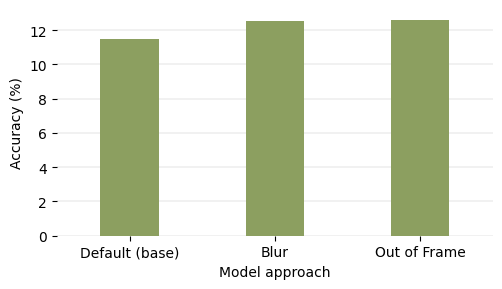

In [ ]:
# Mean VQA models acc improvement

mean_models_vqa_acc = df_blr[df_blr["rej_perc"] == 0].mean()["vqa_acc"]

data = { "model_type" : ["Default (base)"],
            "acc" : [mean_models_vqa_acc],
        }

# For every flaw detection model results
for i, df in enumerate([df_blr, df_frm]):
    df["rej_perc"] = df["rej_perc"].astype(int)
    df_50 = df[(df["rej_perc"] == 50)] #& (df["rej_perc"] <= 60)]
    mean_flaw_vqa_acc = df_50.groupby("vqa_model_type").mean().mean()["vqa_acc"]

    flaw = "Blur" if i == 0 else "Out of Frame"
    data["model_type"].append(flaw)
    data["acc"].append(mean_flaw_vqa_acc)

flaw_vqa_df = pd.DataFrame.from_dict(data, orient='index').T
g = sns.catplot(x="model_type", y="acc", data=flaw_vqa_df,
                     aspect=2, kind="bar", legend=False, palette=["#90a955"],
                     height=3, width=.4)
g.ax.set_axisbelow(True)
g.ax.yaxis.grid(color='gray', linewidth=0.15)
g.set(xlabel="Model approach", ylabel="Accuracy (%)")
g.fig.set_size_inches(5,3)
g.despine(left=True, bottom=True)

plt.show()


In [ ]:
# Save VQA models results after implementing flaw detection models

map_type = { "HF_OCR_google_answer" : "PromptCap + GoogleOCR",
                "HF_OCR_answer" : "PromptCap + EasyOCR",
                "HF_NON_OCR_answer": "PromptCap",
            "SF_LAVIS" : "BLIP-VQA",
            "ViLT" : "ViLT",
            "BLIP2-VQA" : "BLIP2-VQA",
            
        }

map_flaw = {0 : "BLR", 1 : "FRM", 2 : "MC"}
vqa_models_def_acc = df_blr[df_blr["rej_perc"] == 0]

for i, df in enumerate([df_blr, df_frm]):
    vqa_models_flaw_acc = df[df["rej_perc"] == 50]
    flaw_imprv_df = pd.merge(vqa_models_def_acc, vqa_models_flaw_acc, on="vqa_model_type", 
                 suffixes=("_base", f"_{map_flaw[i]}"))
    flaw_imprv_df = flaw_imprv_df.drop(columns=["rej_perc_base", f"rej_perc_{map_flaw[i]}"])
    flaw_imprv_df["vqa_model_type"] = c["vqa_model_type"].map(map_type)
    sf = f"/media/arnau/SSD/VizWiz/results/{map_flaw[i]}_vqa_models_acc.csv"
    flaw_imprv_df.to_csv(sf, index=False)


/tmp/ipykernel_3047/136380710.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


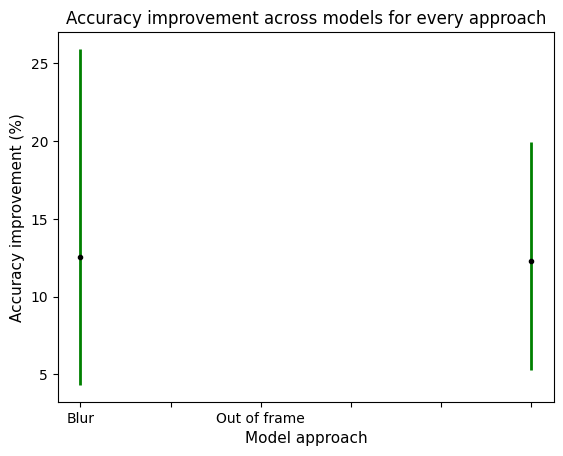

In [ ]:
mins = np.append(df_blr.groupby("vqa_model_type")["vqa_acc"].min().min(), 
          df_frm.groupby("vqa_model_type")["vqa_acc"].min().min())
maxes = np.append(df_blr.groupby("vqa_model_type")["vqa_acc"].max().max(), 
          df_frm.groupby("vqa_model_type")["vqa_acc"].max().max())
means = np.append(df_blr.groupby("vqa_model_type")["vqa_acc"].mean().mean(), 
          df_frm.groupby("vqa_model_type")["vqa_acc"].mean().mean())
std = np.append(df_blr.groupby("vqa_model_type")["vqa_acc"].std().std(), 
          df_frm.groupby("vqa_model_type")["vqa_acc"].std().std())

# create stacked errorbars:
fig, ax = plt.subplots()
#ax.errorbar(np.arange(len(mins)), means, std, fmt='ok', lw=3)
ax.errorbar(np.arange(len(mins)), means, [means - mins, maxes - means],
             fmt='.k', ecolor='green', lw=2)
ax.set_title("Accuracy improvement across models for every approach")

labels = ['' for item in ax.get_xticklabels()]
labels[1] = "Blur"
labels[3] = "Out of frame"
labels[7] = "VQA-CTX"

ax.set_xticklabels(labels)
ax.set_xlabel('Model approach', fontsize=11)
ax.set_ylabel('Accuracy improvement (%)', fontsize=11)
plt.show()

In [ ]:
for flaw_model_type in ["BLR", "FRM"]:
    model_path = '../outputs/best_' + flaw_model_type + '_convnext.pth'
    flaw_model_params = load_model(model_path)
    dict_vqa_acc = get_dict_vqa_acc()
    

    

In [ ]:
data = {"model_type": [],
        "thr": [], 
        "p_imgs_rej": [],
      "acc": []}

# Remap models naming


In [ ]:
blur_results = []
rej_rates = np.flip(np.arange(0., 1.1, 0.1), 0)

# For every rejection rate, compares the default model (rej_rates = 0.0) with 
for rr in rej_rates:
    filtered_data = get_clear_images(model_output_data, (model, device, rr), multiclass=multiclass)
    for typ in get_model_types(model_output_data)[:-1]: # Don't use the BLIP2-CTX-VQA model yet (the last one)
        res = evaluate_acc_promptcap(filtered_data, typ)
        p_imgs_rej = percent_imgs_rejected(model_output_data, filtered_data)
        if len(filtered_data) == 0:
            acc = 100.
        else:
            acc = (sum(res) / len(res)) * 100
        blur_results.append((typ, acc))
        #print(f"--> {typ}: {acc:.4f}%")
        try:
            model_type = map_type[typ]
        except:
            model_type = typ
        data["model_type"].append(model_type)
        data["acc"].append(acc)
        data["thr"].append(rr)
        data["p_imgs_rej"].append(p_imgs_rej)

NameError: name 'model' is not defined

In [ ]:
df = pd.DataFrame.from_dict(data)
#df.sort_values('rej_rate', ascending=True)

In [ ]:
df.sort_values('p_imgs_rej', ascending=True)

---

**Visualization** 

In [ ]:
df = df[df["acc"] != 100.]

plt.figure(figsize=(7,4))
for typ in get_model_types(model_output_data)[:-1]:
    try:
        typ = map_type[typ]
    except:
        typ = typ
    data = df[df["model_type"] == typ].sort_values('p_imgs_rej')

    plt.plot(data["p_imgs_rej"].tolist(),
            data["acc"].tolist(), label=typ)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5, fontsize=7)
    plt.xlabel("Percentage of rejected images")
    plt.ylabel("Accuracy (%)")
plt.title("VQA models accuracies using a multiclass filtering model")
plt.show()

In [ ]:
def calculate_df(model):
    cdata = {"model_type": [],
                      "acc": [],
                   "acc_w_blur_model": []
            }
                #"acc_imprv" : []}

    thr = 0.1
    filt_data = get_clear_images(model_output_data, (model, device, thr), multiclass=multiclass)

    for typ in get_model_types(model_output_data)[:-1]:
        res = evaluate_acc_promptcap(model_output_data, typ)
        res_filt = evaluate_acc_promptcap(filt_data, typ)
        try:
            model_type = map_type[typ]
        except:
            model_type = typ
        acc = (sum(res) / len(res)) * 100
        accwflaw = (sum(res_filt) / len(res_filt)) * 100
        cdata["model_type"].append(model_type)
        cdata["acc"].append(acc)
        cdata["acc_w_blur_model"].append(accwflaw)
        #cdata["acc_imprv"].append(accwflaw - acc)
        
    return pd.DataFrame.from_dict(cdata)

Accuries comparison

In [ ]:
df_c = calculate_df(model)
df_c

NameError: name 'calculate_df' is not defined

## Models improvement

In [ ]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# plot data in stack manner of bar type
df_c.plot(x='model_type', kind='bar', stacked=False, title='')
plt.show()


In [ ]:
# Average model improvement across all models
#mean = (df_c["acc_w_blur_model"].mean() + df_c["acc"].mean()) / 2
#avg_imp = (df_c["acc_imprv"].mean() / mean) * 100
#avg_imp

In [ ]:
model_classes = ["BLR", "FRM", "MC"]
     
c = []
for mc in model_classes:
    # Load and prepare filtering model
    num_classes = 1 if mc in ["BLR", "FRM"] else 4
    multiclass = True if num_classes > 1 else False
    model_path = f'../outputs/best_{mc}_convnext.pth'
    model = initialize_model(model_path, num_classes)
    model_params = (model, device)
    thr = 0.1
    
    # Filter data
    filt_data = get_clear_images(model_output_data, (model, device, thr), multiclass=multiclass)
    # Create df with results
    df_c = calculate_df(model)

    vqa_model_acc_w_improv = ((df_c["acc_w_blur_model"] - df_c["acc"]) / (df_c["acc"])) * 100
    
    df_c["model_class"] = mc
    df_c["vqa_model_acc_w_improv"] = vqa_model_acc_w_improv
    df_c.set_index('model_class', inplace=True)
    c.append(df_c)
    
df_f = pd.concat(c)

In [ ]:
#df_m = pd.DataFrame.from_dict(df_f)
#df_m.set_index('model_class', inplace=True)
#df_m.plot(x='model_type', kind='bar', stacked=False, title='')
#plt.show()
#df_m

## Models accuracy using Vision Language Models with context

Can a visual language model (BLIP2-VQA) 

In [ ]:
res_blip2 = evaluate_acc_promptcap(model_output_data, "BLIP2-VQA")
res_blip2_ctx = evaluate_acc_promptcap(filt_data, "BLIP2-CTX-VQA")

acc_blip2 = (sum(res_blip2) / len(res_blip2)) * 100
acc_blip2_ctx = (sum(res_blip2_ctx) / len(res_blip2_ctx)) * 100

df_f.loc["VQA-CTX", "model_type"] = "BLIP2-VQA"
df_f.loc["VQA-CTX", "acc"] = acc_blip2
df_f.loc["VQA-CTX", "acc_w_blur_model"] = acc_blip2_ctx # BLIP2-CTX-VQA acc
df_f.loc["VQA-CTX", "vqa_model_acc_w_improv"] = ((acc_blip2_ctx - acc_blip2) / acc_blip2) * 100
df_f

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

mins = df_f.groupby("model_class").min()["vqa_model_acc_w_improv"].to_numpy()
maxes = df_f.groupby("model_class").max()["vqa_model_acc_w_improv"].to_numpy()
means = df_f.groupby("model_class").mean()["vqa_model_acc_w_improv"].to_numpy()
std = df_f.groupby("model_class").std()["vqa_model_acc_w_improv"].to_numpy()

# create stacked errorbars:
fig, ax = plt.subplots()
#ax.errorbar(np.arange(len(mins)), means, std, fmt='ok', lw=3)
ax.errorbar(np.arange(len(mins)), means, [means - mins, maxes - means],
             fmt='.k', ecolor='green', lw=2)
ax.set_title("Accuracy improvement across models for every approach")

labels = ['' for item in ax.get_xticklabels()]
labels[1] = "Blur"
labels[3] = "Out of frame"
labels[5] = "Multi-class"
labels[7] = "VQA-CTX"

ax.set_xticklabels(labels)
ax.set_xlabel('Model approach', fontsize=11)
ax.set_ylabel('Accuracy improvement (%)', fontsize=11)
plt.show()